In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays
import logging

sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../scripts'))
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
# Configure logging
logging.basicConfig(level=logging.INFO,      format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Imported libraries and configured logging.")

2024-09-21 16:52:19,473 - INFO - Imported libraries and configured logging.


In [2]:
logger.info("import functions fromscripts.")
from data_processing import missing_values_table,handle_missing_data,remove_all_columns_outliers

2024-09-21 16:52:19,491 - INFO - import functions fromscripts.


In [3]:
# 1. Data Loading and Initial Inspection
logger.info("loaded store,train and test dataset")
store_data = pd.read_csv('../data/store.csv')
train_data=pd.read_csv('../data/train.csv')
test_data=pd.read_csv('../data/test.csv')



2024-09-21 16:52:19,505 - INFO - loaded store,train and test dataset
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\2753626770.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv('../data/train.csv')


In [4]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
logger.info(f'Show shape of datasets')
print(f'\nshape of data sets\n')
print(f'Store dataset:{store_data.shape}')
print(f'Train dataset:{train_data.shape}')
print(f'Test dataset:{test_data.shape}')

2024-09-21 16:52:20,309 - INFO - Show shape of datasets



shape of data sets

Store dataset:(1115, 10)
Train dataset:(1017209, 9)
Test dataset:(41088, 8)


In [8]:
# Check for missing values of Store data
logger.info(f'Missing Values in Store data\n\n')
missing_values_df = missing_values_table(store_data)
print("\n\nMissing Values in Store data:\n\n")
print(missing_values_df)

2024-09-21 16:52:20,414 - INFO - Missing Values in Store data




Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


Missing Values in Store data:


                           Missing Values  % of Total Values    Dtype
Promo2SinceYear                       544               48.8  float64
Promo2SinceWeek                       544               48.8  float64
PromoInterval                         544               48.8   object
CompetitionOpenSinceMonth             354               31.7  float64
CompetitionOpenSinceYear              354               31.7  float64
CompetitionDistance                     3                0.3  float64


In [9]:
# Check for missing values of Train data
missing_values_df = missing_values_table(train_data)
print("Missing Values in Train data:\n\n")
print(missing_values_df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Missing Values in Train data:


Empty DataFrame
Columns: [Missing Values, % of Total Values, Dtype]
Index: []


In [10]:
# Check for missing values of Test data
missing_values_df = missing_values_table(test_data)
print("Missing Values in Test data:\n\n")
print(missing_values_df)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.
Missing Values in Test data:


      Missing Values  % of Total Values    Dtype
Open              11                0.0  float64


#### Missing value Analysis
* Test data  open attribute have 11 missing values
* Train data no missing value and
* Store data 6 columns have missing value

#### Handling missing value

In [11]:
#Competition Distance has 3 null values. They can be replaced by median competition distance, since fields like distances are prone to outliers.
logger.info(f'Handling Missing values\n\n')
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(),inplace=True)

#Competition since month has considerable amount of NaN values. It's safe to use mode value of duration to replace null values
store_data['CompetitionOpenSinceMonth'].fillna(int(store_data['CompetitionOpenSinceMonth'].mode()),inplace=True)

#Similarly for competition since year
store_data['CompetitionOpenSinceYear'].fillna(int(store_data['CompetitionOpenSinceYear'].mode()),inplace=True)

2024-09-21 16:52:23,837 - INFO - Handling Missing values


C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\454359574.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(),inplace=True)
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\454359574.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  store_data['CompetitionOpenSinceMonth'].fillna(int(store

In [12]:
#The NaN values in PromoInterval, Promo2SinceYear, and Promo2SinceWeek can be replaced by 0 or 'None' depending on the dtype.
logger.info(f' NaN values in PromoInterval, Promo2SinceYear, and Promo2SinceWeek can be replaced by 0 or "None" depending on the dtype\n\n')
promos =['PromoInterval' , 'Promo2SinceYear', 'Promo2SinceWeek']
for col in promos:
   if store_data[col].dtype == object:
         store_data[col].fillna('None',inplace=True)
   else:
         store_data[col].fillna(0,inplace=True)

2024-09-21 16:52:24,552 - INFO -  NaN values in PromoInterval, Promo2SinceYear, and Promo2SinceWeek can be replaced by 0 or "None" depending on the dtype


C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\3587846322.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data[col].fillna('None',inplace=True)
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\3587846322.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will chan

In [13]:
# handling Open missing value of test data
logger.info("missing value of test data in Open column")
test_data['Open'].fillna(test_data['Open'].median(),inplace=True)


2024-09-21 16:52:25,102 - INFO - missing value of test data in Open column
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\600629197.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Open'].fillna(test_data['Open'].median(),inplace=True)


In [14]:
print(store_data.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


In [15]:
test_data.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

#### Check and Handle outlier

In [16]:
logger.info("describe the store data for more analaysis")
store_data.describe()

2024-09-21 16:52:29,620 - INFO - describe the store data for more analaysis


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5396.614350,7.788341,2010.043946,0.512108,12.083408,1030.239462
std,322.01708,7654.513635,2.779130,5.500844,0.500078,15.542241,1006.038782
min,1.00000,20.000000,1.000000,1900.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,6.000000,2008.000000,0.000000,0.000000,0.000000
50%,558.00000,2325.000000,9.000000,2012.000000,1.000000,1.000000,2009.000000
75%,836.50000,6875.000000,9.000000,2013.000000,1.000000,22.000000,2012.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [17]:
# Check for missing values of Test data
missing_values_df = remove_all_columns_outliers(store_data,'zscore')
new_store_data=missing_values_df.copy()

In [18]:
new_store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
5,6,a,a,310.0,12.0,2013.0,0,0.0,0.0,None


* Convert Date to datetime so we can divide it to month, day, and year for time-required explorations.

In [19]:
logger.info("Convert Date to datetime so we can divide it to month, day, and year for time-required explorations.")
train_data['Date']=pd.to_datetime(train_data['Date'])
# Extract year, month, and day
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

test_data['Date']=pd.to_datetime(test_data['Date'])

# Extract year, month, and day
test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day

2024-09-21 16:52:33,645 - INFO - Convert Date to datetime so we can divide it to month, day, and year for time-required explorations.


* .Merge separate tables; train & store data

In [20]:
logger.info("merge train and store data\n")
train_store_data = pd.merge(train_data, new_store_data, how='inner', on='Store')
train_store_data.info()

2024-09-21 16:52:35,990 - INFO - merge train and store data



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990075 entries, 0 to 990074
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      990075 non-null  int64         
 1   DayOfWeek                  990075 non-null  int64         
 2   Date                       990075 non-null  datetime64[ns]
 3   Sales                      990075 non-null  int64         
 4   Customers                  990075 non-null  int64         
 5   Open                       990075 non-null  int64         
 6   Promo                      990075 non-null  int64         
 7   StateHoliday               990075 non-null  object        
 8   SchoolHoliday              990075 non-null  int64         
 9   Year                       990075 non-null  int32         
 10  Month                      990075 non-null  int32         
 11  Day                        990075 non-null  int32   

* Test & Store data

In [21]:
logger.info("Merge test and store data")
test_store_data = pd.merge(test_data, new_store_data, how='inner', on='Store')
test_store_data.info()

2024-09-21 16:52:38,245 - INFO - Merge test and store data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40080 entries, 0 to 40079
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         40080 non-null  int64         
 1   Store                      40080 non-null  int64         
 2   DayOfWeek                  40080 non-null  int64         
 3   Date                       40080 non-null  datetime64[ns]
 4   Open                       40080 non-null  float64       
 5   Promo                      40080 non-null  int64         
 6   StateHoliday               40080 non-null  object        
 7   SchoolHoliday              40080 non-null  int64         
 8   Year                       40080 non-null  int32         
 9   Month                      40080 non-null  int32         
 10  Day                        40080 non-null  int32         
 11  StoreType                  40080 non-null  object        
 12  Asso

In [22]:
train_store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,6,5,2015-07-31,5651,589,1,1,0,1,2015,...,31,a,a,310.0,12.0,2013.0,0,0.0,0.0,None


In [23]:
test_store_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,a,c,24000.0,4.0,2013.0,0,0.0,0.0,None
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,a,a,7520.0,10.0,2014.0,0,0.0,0.0,None
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,a,c,2030.0,8.0,2000.0,0,0.0,0.0,None


### Data Exploration and Visualization

In [24]:
logger.info('Importing the visualyzer class from scripts')
# Import the Analyzer class
from data_visualization import Visualyzer
# Create instance of EDAnalyzer
vlyr = Visualyzer(train_store_data, test_store_data)

2024-09-21 16:52:44,240 - INFO - Importing the visualyzer class from scripts


2024-09-21 16:52:45,544 - INFO - Checking the distribtion of promotions


Promo Contingency Table:
 Dataset   Test   Train
Promo                 
0        24215  612361
1        15865  377714
Promo2 Contingency Table:
 Dataset   Test   Train
Promo2                
0        16416  484481
1        23664  505594
Training Promo Distribution:
 Promo
0    0.6185
1    0.3815
Name: proportion, dtype: float64
Testing Promo Distribution:
 Promo
0    0.604167
1    0.395833
Name: proportion, dtype: float64
Training Promo2 Distribution:
 Promo2
1    0.510662
0    0.489338
Name: proportion, dtype: float64
Testing Promo2 Distribution:
 Promo2
1    0.590419
0    0.409581
Name: proportion, dtype: float64


2024-09-21 16:52:46,370 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-21 16:52:46,379 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-21 16:52:46,416 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-21 16:52:46,422 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-21 16:52:46,447 - INFO - Using categorical units to plot a list of strings that are all parsable as 

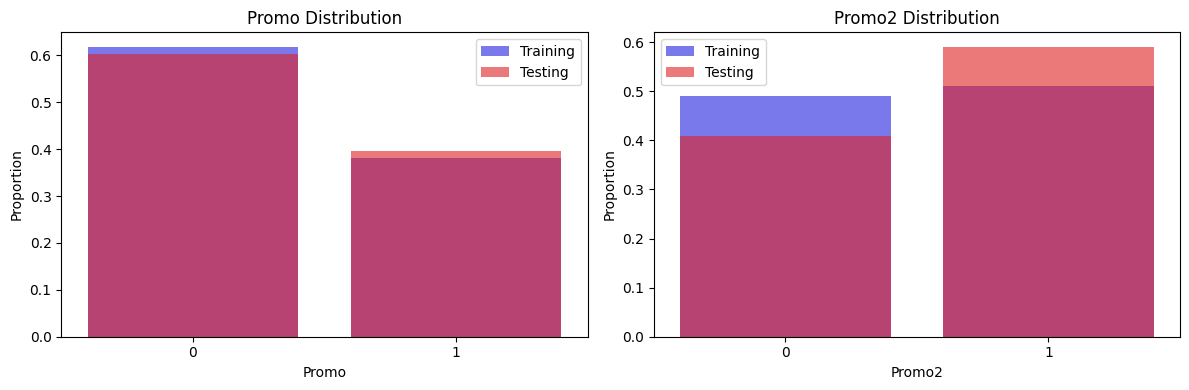

In [25]:
logger.info('Checking the distribtion of promotions')
# Check the distributions
vlyr.check_promotion_distribution()

2024-09-21 16:53:39,567 - INFO - Comparing sales behavior


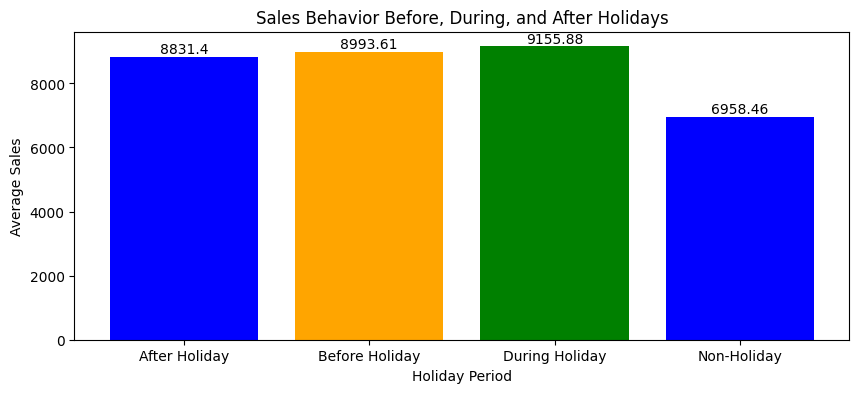

In [26]:
logger.info('Comparing sales behavior')
# Compare sales behaviour
vlyr.compare_sales_behavior()

#### Overview

* Sales After Holidays:
Sales tend to be slightly higher following holidays compared to regular times. This could indicate that customers engage in more shopping once stores resume operations after holiday closures.

* Sales Before Holidays:
Sales are elevated leading up to holidays, likely because customers are preparing for the holiday period by purchasing products in advance, either due to store closures or upcoming celebrations.

* Sales During Holidays:
Sales during the holiday season are similar to those before and after, suggesting that some stores remain operational or that there is steady consumer activity throughout the holidays.

* Sales on Non-Holiday Periods:
Average sales during non-holiday times are significantly lower than those during holiday-related periods, implying that holidays have a strong positive influence on customer purchasing behavior.

2024-09-21 16:57:05,009 - INFO - Finding seasonal sales behavior


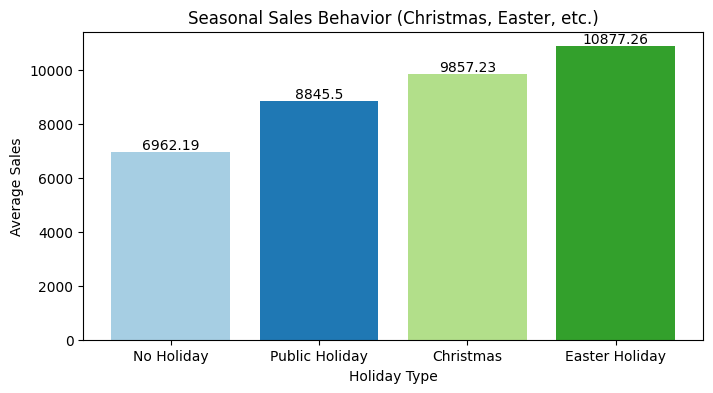

In [27]:
logger.info('Finding seasonal sales behavior')
# Find seasonal sales behavior
vlyr.seasonal_sales_behavior()

* Easter and Christmas experience the highest average sales, suggesting that customers tend to increase their shopping during these holidays.

* Sales also rise noticeably on public holidays when compared to regular days.

* On non-holiday days, the average sales are the lowest, which is expected as holidays typically boost consumer spending.

2024-09-21 16:58:35,029 - INFO - Comparing the correlation between Sales and Customers


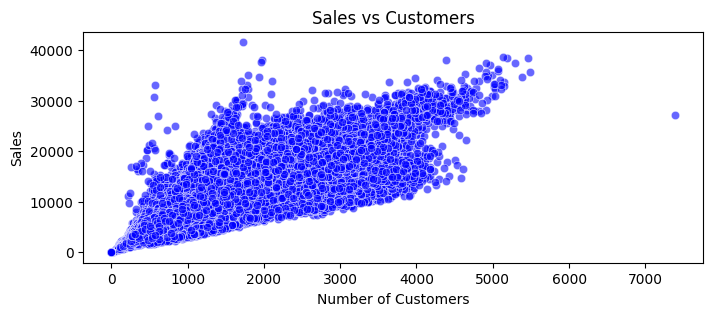

In [28]:
logger.info('Comparing the correlation between Sales and Customers')
# Scatter plot to visualize Sales vs Customers
plt.figure(figsize=(8, 3))
sns.scatterplot(x='Customers', y='Sales', data=train_data, color='blue', alpha=0.6)

# Add labels and title
plt.title('Sales vs Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Sales')

plt.show()

Summary

* Upward Trend: Sales generally increase as the number of customers rises, as shown by the upward slope of the data points.

* Clustering: The data points cluster around a general upward trendline, suggesting a consistent relationship.

2024-09-21 16:59:41,263 - INFO - Analyzing the effect of each Promo type


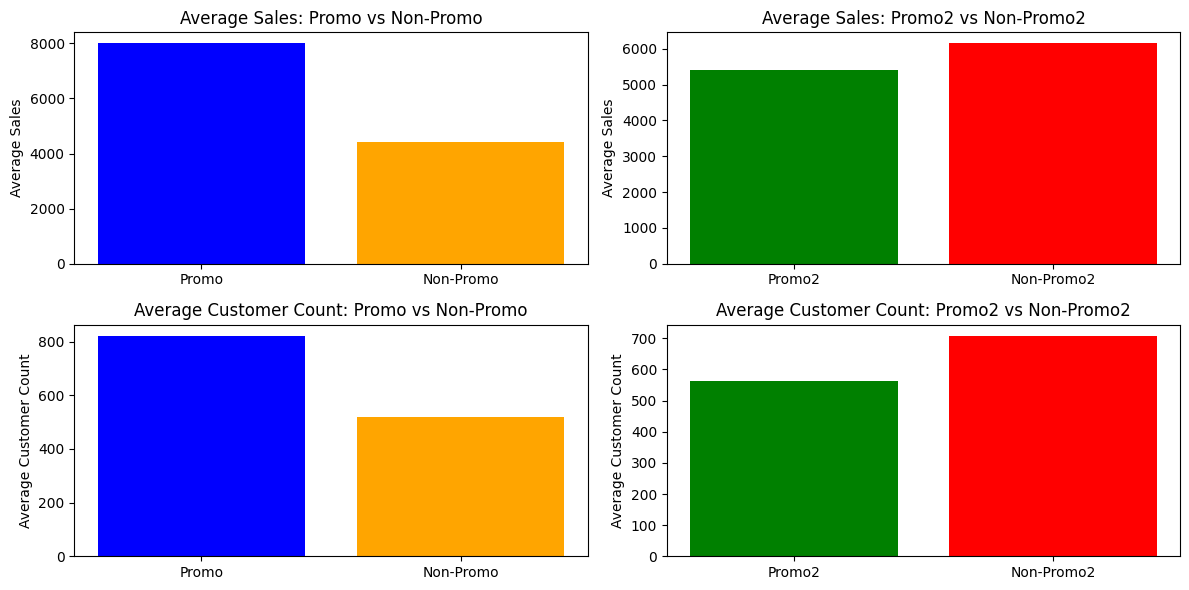

In [29]:
logger.info('Analyzing the effect of each Promo type')
# Plot the average sales and cstomer in each promotion type
vlyr.plot_promo_impact()

#### Summary

#### Impact of Promotions on Sales

- **Promo**:  
  Stores running promotions (`Promo=1`) experience significantly higher sales compared to those not running promotions (`Promo=0`). This indicates that promotions are effective in boosting sales.

- **Promo2**:  
  Stores with ongoing promotions (`Promo2=1`) see slightly lower sales than those without (`Promo2=0`). This suggests that long-term or consecutive promotions may be less effective, likely due to diminishing returns over time.

#### Impact of Promotions on Existing Customers

- **Promotional Effectiveness**:  
  Both promotional types (`Promo` and `Promo2`) attract more customers, with `Promo` having a stronger impact. This shows that promotional activities successfully increase customer traffic.

- **Long-Term Promotions**:  
  While `Promo2` continues to attract more customers, the increase is less pronounced compared to `Promo`. This suggests that the effectiveness of ongoing promotions diminishes over time.


2024-09-21 17:05:19,109 - INFO - Analyzing the trends of the customer behavior


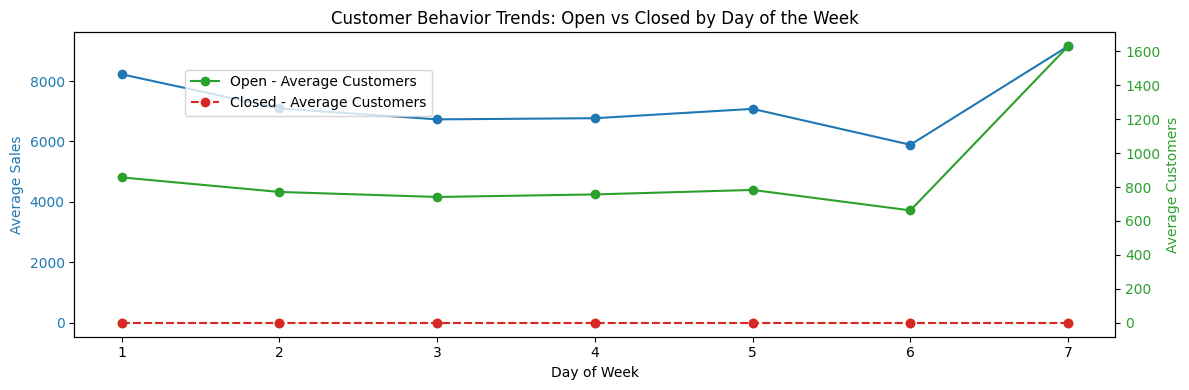

In [32]:
logger.info('Analyzing the trends of the customer behavior')
# Analyze trends of customer behavior
vlyr.analyze_trend()

#### Trend Analysis Result

**Open Times**:
* The number of customers remains relatively stable during weekdays when the store is open.

* Sales show a slight decline through weekdays but drop notably on the last weekday (Day 5). However, there is a significant increase in both customer numbers and sales from the weekend days (Day 6-7).

**Closed Times**:

Both customer numbers and sales remain constant at zero when the store is closed

In [34]:
# Ensure you have the correct DataFrame and reset index if 'Store' is the index
data = train_store_data.copy()  # Use your actual DataFrame
data = data.reset_index()  # Ensure 'Store' is a column, not the index

# Filter stores open on weekdays (Monday to Friday) and group by 'Store'
weekday_open_stores = data[(data['DayOfWeek'] <= 5) & (data['Open'] == 1)]

# Count the number of unique weekdays each store is open
open_weekday_stores = weekday_open_stores.groupby('Store')['DayOfWeek'].nunique()

# Identify stores that are open on all weekdays (5 days)
open_all_weekdays = open_weekday_stores[open_weekday_stores == 5].index

# Calculate average weekend sales for stores open all weekdays
weekend_sales = data[(data['Store'].isin(open_all_weekdays)) & (data['DayOfWeek'] >= 6)]
weekend_sales_summary = weekend_sales.groupby('Store')['Sales'].mean()

# Calculate average weekday sales for the same stores
weekday_sales = data[(data['Store'].isin(open_all_weekdays)) & (data['DayOfWeek'] <= 5)]
weekday_sales_summary = weekday_sales.groupby('Store')['Sales'].mean()

# Create a DataFrame comparing average weekday and weekend sales
comparison = pd.DataFrame({
    'Weekday Sales': weekday_sales_summary,
    'Weekend Sales': weekend_sales_summary
})

# Display the comparison DataFrame
display(comparison.sort_values(by='Weekday Sales', ascending=False))

,Weekday Sales,Weekend Sales
Store,,
817,22355.127596,7427.279851
262,19813.574184,22994.376866
1114,19678.379822,10967.750000
562,18577.231454,16441.298507
251,18445.221068,9196.981343
...,...,...
794,3076.216617,1238.820896
543,2914.200297,802.671642
307,2869.813056,671.895522


2024-09-21 17:08:03,166 - INFO - Visualizing the sales by assortemnt type


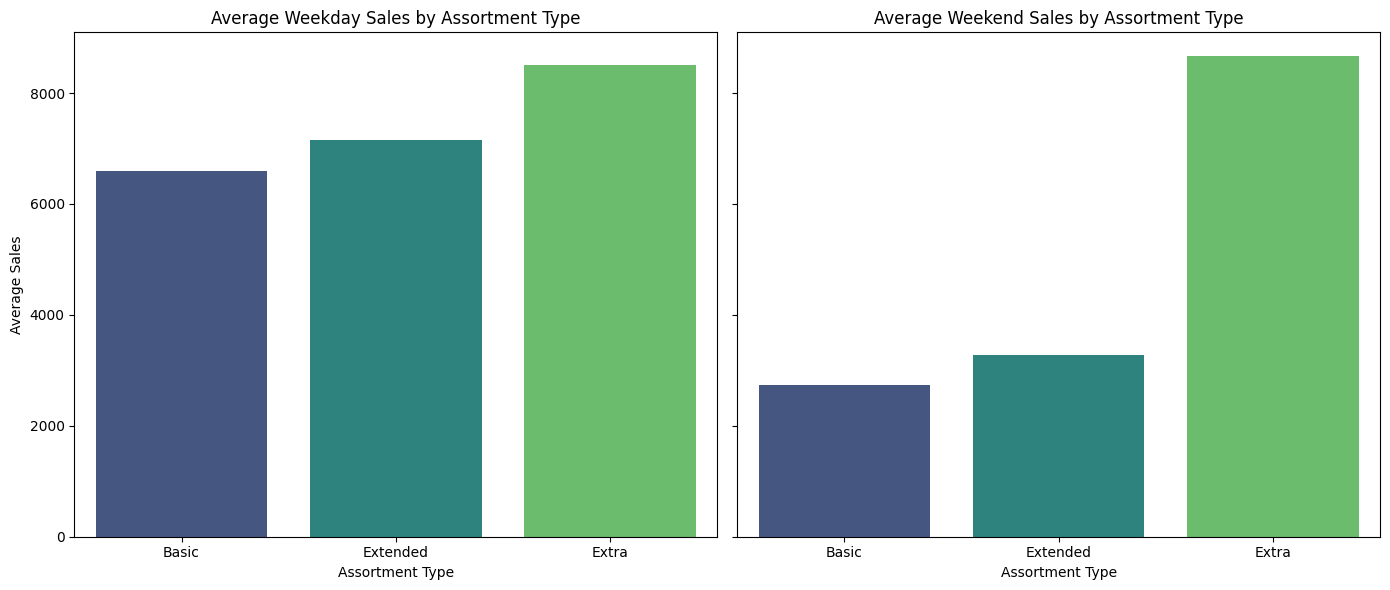

In [35]:
logger.info('Visualizing the sales by assortemnt type')
# Visualize the sales by assortment
vlyr.plot_assortment_sales()

#### Summary

**Weekday Sales:**

Extended and Extra assortment types have consistently higher average weekday sales compared to the Basic assortment type.

Extra has the highest average weekday sales, suggesting that it attracts customers with higher spending power or a demand for a wider range of products.

**Weekend Sales:**

The Extra assortment type again shows the highest average weekend sales. However, the difference between Extended and Basic is less pronounced on weekends, indicating that the impact of assortment type might be less significant during this period.

**How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centers, does the distance matter in that case?**

2024-09-21 17:13:22,799 - INFO - Understanding sales vs competition distance


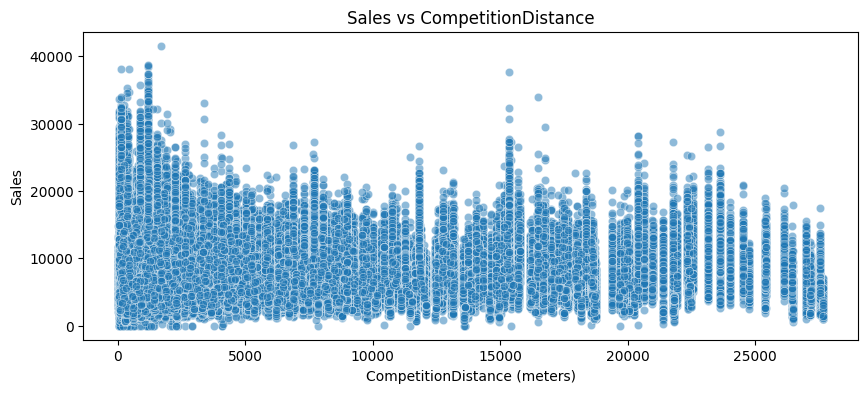

In [37]:
logger.info('Understanding sales vs competition distance')
# Filter the data to only include stores that are open
df = train_store_data[train_store_data['Open'] == 1]

# Scatter plot: Sales vs CompetitionDistance
plt.figure(figsize=(10,4))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df, alpha=0.5)
plt.title('Sales vs CompetitionDistance')
plt.xlabel('CompetitionDistance (meters)')
plt.ylabel('Sales')
plt.show()

2024-09-21 17:14:38,063 - INFO - Grouping sales by distance
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\3632895038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'DistanceBin'] = pd.cut(df['CompetitionDistance'], bins=bins, labels=labels, include_lowest=True)


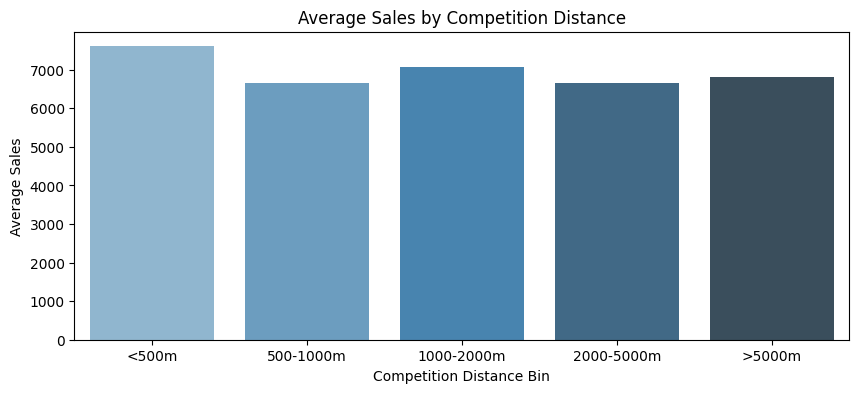

In [38]:
logger.info('Grouping sales by distance')
# Create bins for CompetitionDistance
bins = [0, 500, 1000, 2000, 5000, df['CompetitionDistance'].max()]
labels = ['<500m', '500-1000m', '1000-2000m', '2000-5000m', '>5000m']
df.loc[:,'DistanceBin'] = pd.cut(df['CompetitionDistance'], bins=bins, labels=labels, include_lowest=True)

# Group by DistanceBin and calculate the mean Sales
distance_sales = df.groupby('DistanceBin', observed=False)['Sales'].mean().reset_index()

# Bar plot: Average Sales by Distance Bin
plt.figure(figsize=(10,4))
sns.barplot(x='DistanceBin', y='Sales', hue='DistanceBin', data=distance_sales, palette='Blues_d')
plt.title('Average Sales by Competition Distance')
plt.xlabel('Competition Distance Bin')
plt.ylabel('Average Sales')
plt.show()

* Stores with nearby competitors (<500m) outperform other stores in terms of sales, likely due to higher customer foot traffic and location in busy areas like city centers.

* Mid-range competition (1000-2000m) also supports slightly higher-than-average sales, suggesting that stores in moderately competitive zones still perform well, perhaps benefiting from drawing customers from a wider range of stores.

2024-09-21 17:15:00,242 - INFO - Identifying the city center
C:\Users\asmam\AppData\Local\Temp\ipykernel_11872\951436629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'CityCenter'] = df['CompetitionDistance'] < 500


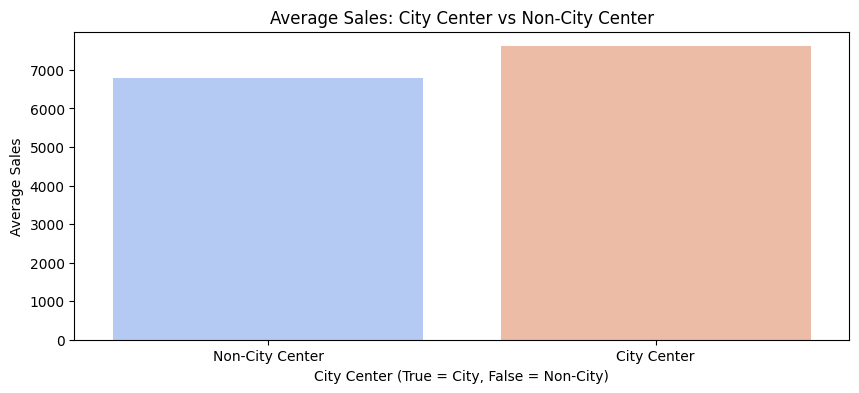

In [39]:
logger.info('Identifying the city center')
# Create a flag for city center stores (CompetitionDistance < 500 meters)
df.loc[:,'CityCenter'] = df['CompetitionDistance'] < 500

# Compare sales for stores in city centers vs non-city centers
city_vs_non_city = df.groupby('CityCenter')['Sales'].mean().reset_index()

# Bar plot: Average Sales in City Center vs Non-City Center
plt.figure(figsize=(10,4))
sns.barplot(x='CityCenter', y='Sales', hue='CityCenter', legend=False, data=city_vs_non_city, palette='coolwarm')
plt.title('Average Sales: City Center vs Non-City Center')
plt.xlabel('City Center (True = City, False = Non-City)')
plt.ylabel('Average Sales')
plt.xticks([0, 1], ['Non-City Center', 'City Center'])
plt.show()

* City-center stores show significantly higher average sales than non-city-center stores, which highlights the importance of location in terms of foot traffic and competition.

**How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on have values for competitor distance**

* To analyze how the opening or reopening of new competitors affects stores, particularly for those with initially missing competitor distance values (NA) that later receive valid distances, you can follow these steps:

**Filter the Data:** Identify stores where CompetitionDistance is NA and then check for subsequent entries where this field has valid values.

**Analyze Sales Performance:** Compare sales performance before and after the distance to competitors becomes available.

**Summarize Findings:** Look for trends, such as changes in sales, customer counts, or any patterns indicating the impact of nearby competitors

In [42]:
logger.info('Analyzing the stores before and after opening ')
# Step 1: Ensure the 'CompetitionDistance' and 'CompetitionOpenSinceMonth/Year' columns are properly set
data = train_store_data.reset_index()
unique_stores_with_na = data['Store'].unique()

# Check for subsequent entries of these stores where CompetitionDistance becomes non-NA
# Additionally, look for valid CompetitionOpenSinceMonth and Year
stores_with_competition_appeared = data[
    (data['Store'].isin(unique_stores_with_na)) & 
    (data['CompetitionDistance'].notna()) & 
    (data['CompetitionOpenSinceMonth'].notna()) & 
    (data['CompetitionOpenSinceYear'].notna())
]

# Compare sales before and after the competitor opening (based on CompetitionOpenSinceMonth/Year)
before_after_analysis = []

for store in unique_stores_with_na:
    # Get the data for this store
    store_data = data[data['Store'] == store].copy()
    
    # Find the first entry where the competitor opened (non-NA CompetitionDistance)
    first_valid_competition_entry = store_data[store_data['CompetitionDistance'].notna()].index.min()
    
    # Ensure CompetitionOpenSinceMonth/Year is present to track when the competitor opened
    if pd.notna(first_valid_competition_entry):
        competition_open_date = store_data.loc[first_valid_competition_entry, ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']]
        
        # Calculate sales before and after the competitor opening
        before_competition_sales = store_data.loc[:first_valid_competition_entry - 1, 'Sales'].mean()
        after_competition_sales = store_data.loc[first_valid_competition_entry:, 'Sales'].mean()
        
        # Append results to the list
        before_after_analysis.append({
            'Store': store,
            'Before Competitor (Sales)': before_competition_sales,
            'After Competitor (Sales)': after_competition_sales
        })

# Convert the list to a DataFrame
before_after_analysis_df = pd.DataFrame(before_after_analysis)

# Step 6: Display the analysis of sales before and after competitor appearance
display(before_after_analysis_df)

2024-09-21 17:36:36,979 - INFO - Analyzing the stores before and after opening 


,Store,Before Competitor (Sales),After Competitor (Sales)
0,1,NaN,3945.704883
1,2,NaN,4122.991507
2,3,NaN,5741.253715
3,4,NaN,8021.769639
4,6,NaN,4562.375796
...,...,...,...
1081,1111,NaN,4342.968153
1082,1112,NaN,8465.280255
1083,1113,NaN,5516.180467
1084,1114,NaN,17200.196391


Text(0.5, 1.0, 'Store type Count')

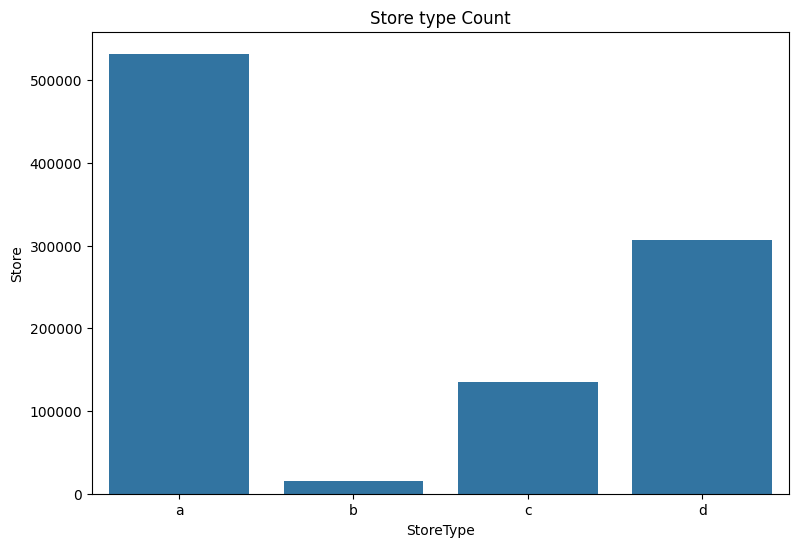

In [42]:
df=train_store_data.groupby('StoreType')['Store'].count().reset_index()
plt.figure(figsize=(9,6))
sns.barplot(x=df.StoreType,y=df.Store)
plt.title('Store type Count')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


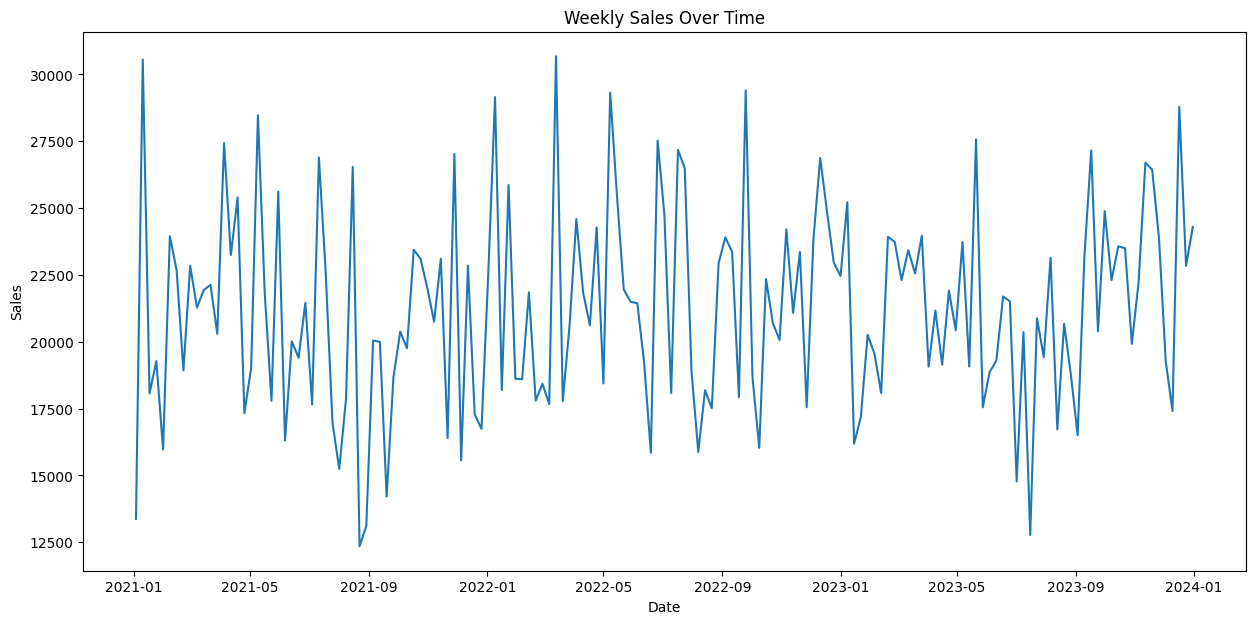

In [48]:
# Create a temporary variable for weekly sales without modifying df
weekly_sales = df['Sales'].resample('W').sum()

# Time series plot of weekly sales
plt.figure(figsize=(15, 7))
plt.plot(weekly_sales.index, weekly_sales)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


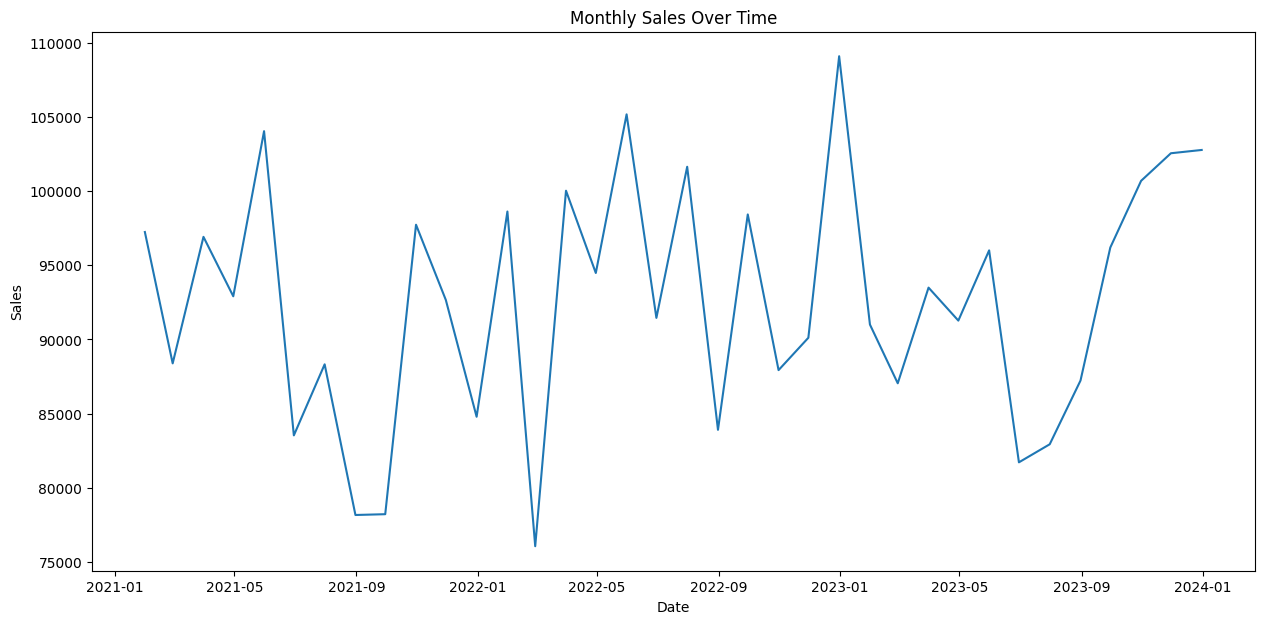

In [11]:
# Resample to monthly data for clearer trends
monthly_sales = df['Sales'].resample('M').sum()
# Monthly sales plot
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales.index, monthly_sales)
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

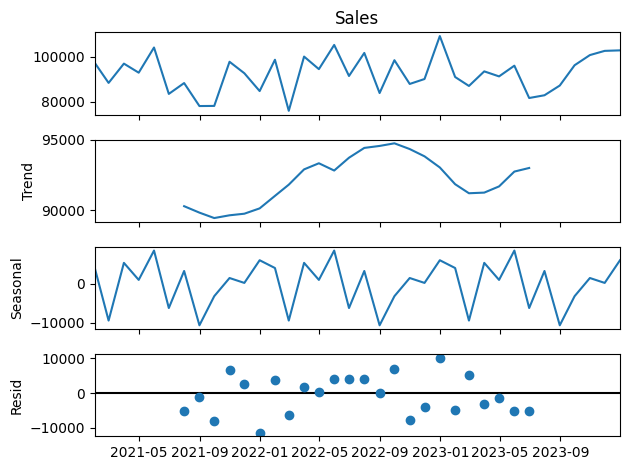

In [12]:

# 3. Seasonal Decomposition
result = seasonal_decompose(monthly_sales, model='additive')
result.plot()
plt.tight_layout()
plt.show()

In [15]:
print(len(monthly_sales))

36


/tmp/ipykernel_9757/2691619.py:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(range(len(acf_values)), acf_values, use_line_collection=True)
/tmp/ipykernel_9757/2691619.py:25: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)


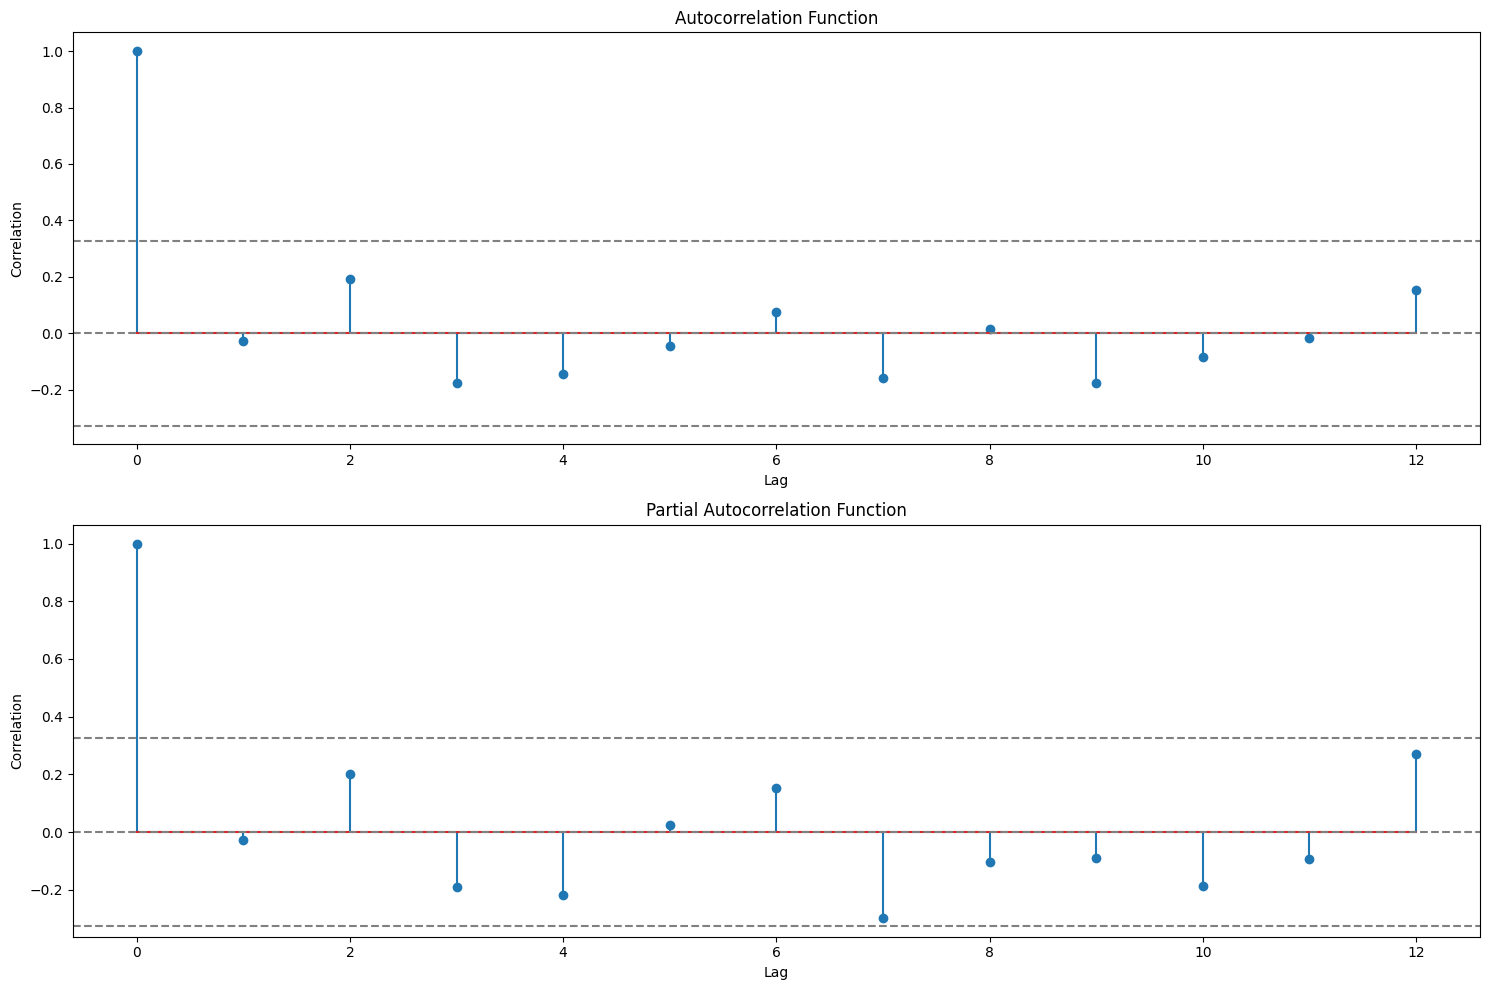

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# Determine number of lags (use 1/3 of data length)
n_lags = len(monthly_sales) // 3  # This will be 12

# Calculate ACF and PACF
acf_values = acf(monthly_sales.dropna(), nlags=n_lags)
pacf_values = pacf(monthly_sales.dropna(), nlags=n_lags)

# Plot ACF and PACF using stem plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot ACF
ax1.stem(range(len(acf_values)), acf_values, use_line_collection=True)
ax1.axhline(y=0, linestyle='--', color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax1.set_title('Autocorrelation Function')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')

# Plot PACF
ax2.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)
ax2.axhline(y=0, linestyle='--', color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax2.axhline(y=1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax2.set_title('Partial Autocorrelation Function')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()


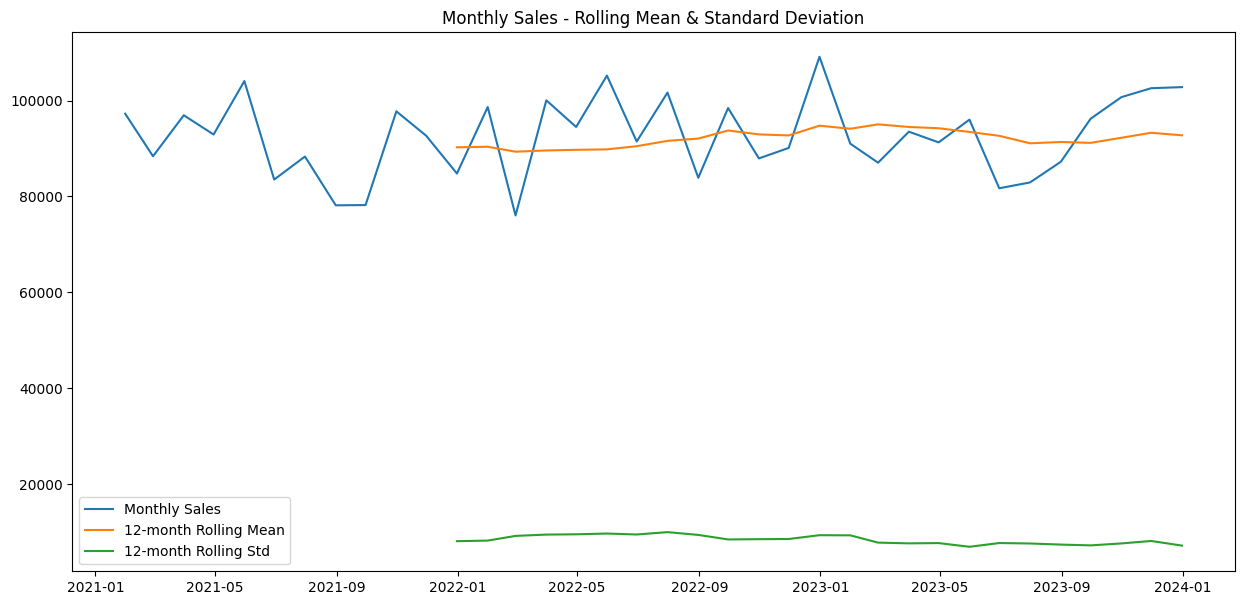

In [18]:
# 5. Rolling statistics
rolling_mean = monthly_sales.rolling(window=12).mean()
rolling_std = monthly_sales.rolling(window=12).std()

plt.figure(figsize=(15, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales')
plt.plot(rolling_mean.index, rolling_mean, label='12-month Rolling Mean')
plt.plot(rolling_std.index, rolling_std, label='12-month Rolling Std')
plt.legend()
plt.title('Monthly Sales - Rolling Mean & Standard Deviation')
plt.show()

In [21]:
# # 6. Year-over-Year comparison
# df['Year'] = df.index.year
# df['Month'] = df.index.month

# yearly_monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().unstack()
# yearly_monthly_sales.plot(figsize=(15, 7))
# plt.title('Monthly Sales by Year')
# plt.xlabel('Month')
# plt.ylabel('Sales')
# plt.legend(title='Year')
# plt.show()

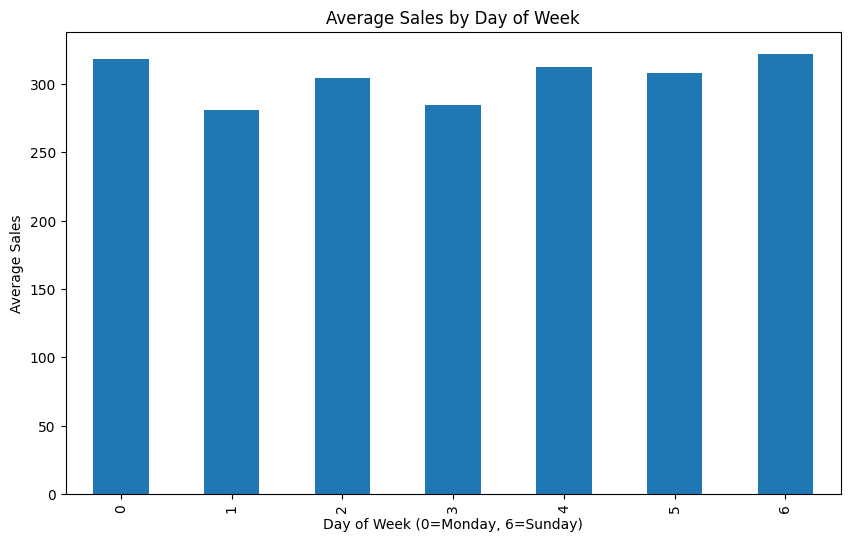

In [20]:
# 7. Day of week patterns
df['DayOfWeek'] = df.index.dayofweek
day_of_week_sales = df.groupby('DayOfWeek')['Sales'].mean()
day_of_week_sales.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.show()

In [26]:
# Create is_holiday column using the holidays library (using US holidays as an example)
us_holidays = holidays.US()  # Change to the appropriate country if needed

# Function to check if a date is a holiday
def is_holiday(date):
    return date in us_holidays

# Apply the function to create the is_holiday column
df['is_holiday'] = df.index.to_series().apply(is_holiday).astype(int)

In [27]:
df

,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales,Year,Month,DayOfWeek,is_holiday
Date,,,,,,,,,,,,
2021-01-01,1,supermarket,1,0,0,0,124,0,2021,1,4,1
2021-01-02,1,pharmacy,1,0,0,0,87,0,2021,1,5,0
2021-01-03,1,supermarket,1,1,0,0,74,778,2021,1,6,0
2021-01-04,1,supermarket,0,1,0,0,0,0,2021,1,0,0
2021-01-05,1,pharmacy,1,1,0,0,76,1002,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,10,pharmacy,1,0,1,0,112,28,2023,12,2,0
2023-12-28,10,convenience,1,0,0,0,111,55,2023,12,3,0
2023-12-29,10,convenience,1,0,0,0,99,0,2023,12,4,0


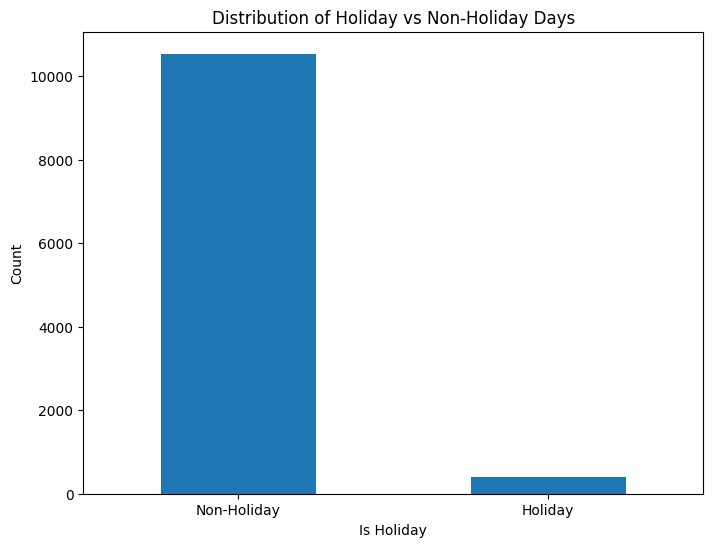

In [28]:

# Visualize distribution of is_holiday
plt.figure(figsize=(8, 6))
df['is_holiday'].value_counts().plot(kind='bar')
plt.title('Distribution of Holiday vs Non-Holiday Days')
plt.xlabel('Is Holiday')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.show()


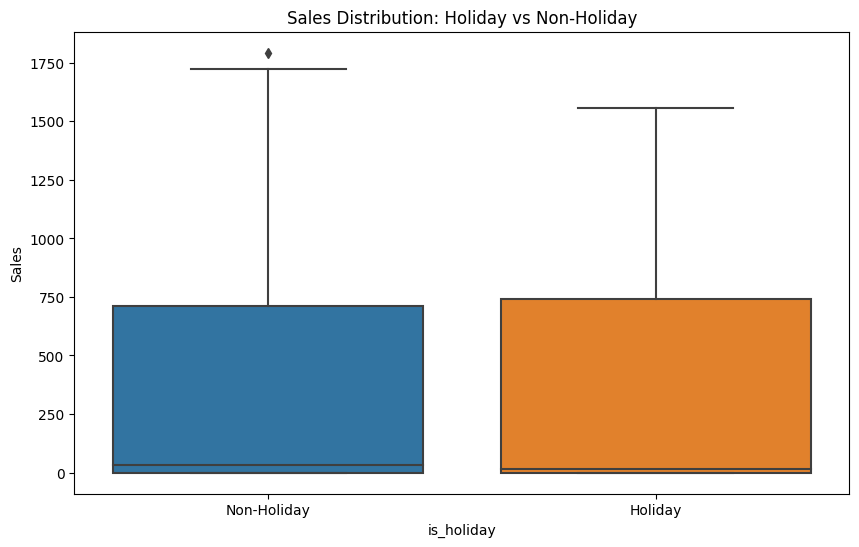

In [32]:

# Visualize sales distribution for holiday vs non-holiday
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Sales', data=df)
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [34]:
# Print summary statistics
print(df.groupby('DayOfWeek')['Sales'].describe())
print("\nHoliday vs Non-Holiday Sales:")
print(df.groupby('is_holiday')['Sales'].describe())

# Print the list of holidays in the dataset
holiday_dates = df[df['is_holiday'] == 1].index.tolist()
print("\nHolidays in the dataset:")
for date in holiday_dates:
    print(f"{date.date()}: {us_holidays.get(date)}")

            count        mean         std  min  25%   50%     75%     max
DayOfWeek                                                                
0          1560.0  318.338462  469.388808  0.0  0.0  34.0  770.50  1639.0
1          1560.0  280.810256  443.543271  0.0  0.0  30.5  291.00  1691.0
2          1560.0  304.339744  462.794149  0.0  0.0  28.0  725.00  1603.0
3          1560.0  284.910897  454.747902  0.0  0.0  23.5  322.25  1793.0
4          1570.0  312.052229  465.506055  0.0  0.0  37.5  742.00  1621.0
5          1570.0  307.989172  469.064582  0.0  0.0  37.5  705.75  1721.0
6          1570.0  321.981529  466.041927  0.0  0.0  43.0  790.00  1697.0

Holiday vs Non-Holiday Sales:
              count        mean         std  min  25%   50%     75%     max
is_holiday                                                                 
0           10540.0  304.158824  461.256830  0.0  0.0  34.0  713.25  1793.0
1             410.0  309.865854  475.748371  0.0  0.0  16.5  742.25  1557.0

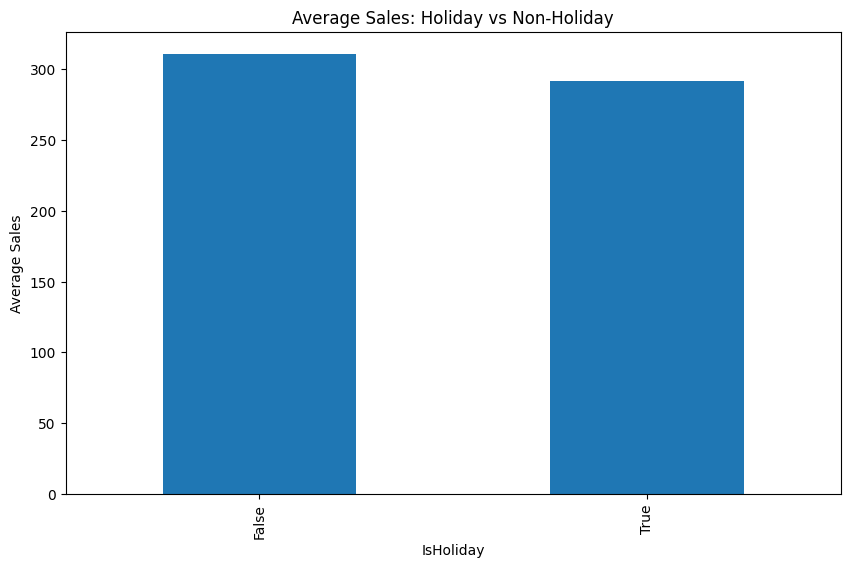

In [35]:
# 8. Checking for holidays effect
df['IsHoliday'] = df['School_Holiday'] | (df.index.month == 12)  # Assuming December is a holiday month
holiday_effect = df.groupby('IsHoliday')['Sales'].mean()
holiday_effect.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Sales')
plt.show()


Monthly Average Sales: Promo vs No Promo
          No Promo        Promo
Date                           
2021-01  34.630137   985.362637
2021-02  28.096939   986.630952
2021-03  34.088372   943.115789
2021-04  31.838095   958.077778
2021-05  40.755760  1023.817204
2021-06  36.028037   881.558140
2021-07  40.277512   791.108911
2021-08  32.000000   864.060976
2021-09  38.575893   915.289474
2021-10  29.728111   981.645161
2021-11  30.840580   927.763441
2021-12  34.017937   887.287356
2022-01  40.640553   965.774194
2022-02  34.883495   930.472973
2022-03  29.212264   957.632653
2022-04  27.779817  1078.414634
2022-05  32.724138   921.037383
2022-06  36.848780   883.157895
2022-07  36.201005   850.918919
2022-08  41.195455   831.511111
2022-09  37.809524  1005.522222
2022-10  30.573991   932.310345
2022-11  38.633028   996.231707
2022-12  41.415459   976.174757
2023-01  37.336323   950.333333
2023-02  42.092308   927.435294
2023-03  34.977064   933.402174
2023-04  31.430622   930.802198

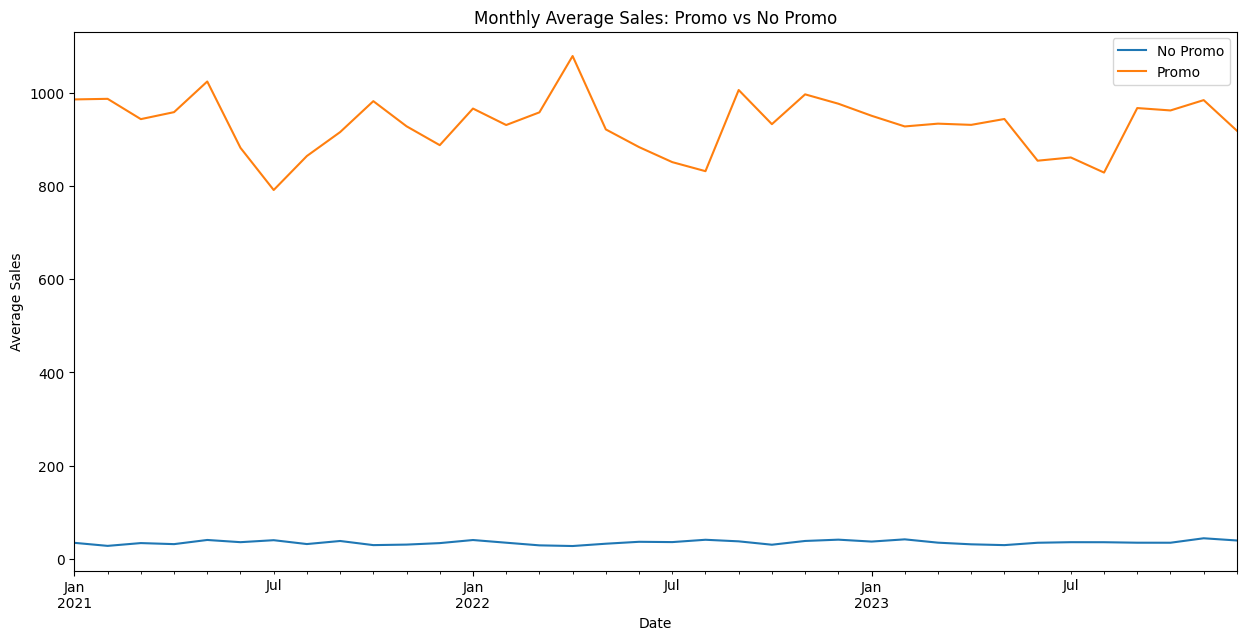

In [38]:
# 9. Promo effect over time
monthly_promo_sales = df.groupby([df.index.to_period('M'), 'Promo'])['Sales'].mean().unstack()

# Rename columns for clarity
monthly_promo_sales.columns = ['No Promo', 'Promo']

# Display the data
print("Monthly Average Sales: Promo vs No Promo")
print(monthly_promo_sales)

# Calculate the difference and percentage increase
monthly_promo_sales['Difference'] = monthly_promo_sales['Promo'] - monthly_promo_sales['No Promo']
monthly_promo_sales['Percentage Increase'] = (monthly_promo_sales['Difference'] / monthly_promo_sales['No Promo']) * 100

print("\nDifference and Percentage Increase:")
print(monthly_promo_sales[['Difference', 'Percentage Increase']])

# Plot
monthly_promo_sales[['No Promo', 'Promo']].plot(figsize=(15, 7))
plt.title('Monthly Average Sales: Promo vs No Promo')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(['No Promo', 'Promo'])
plt.show()

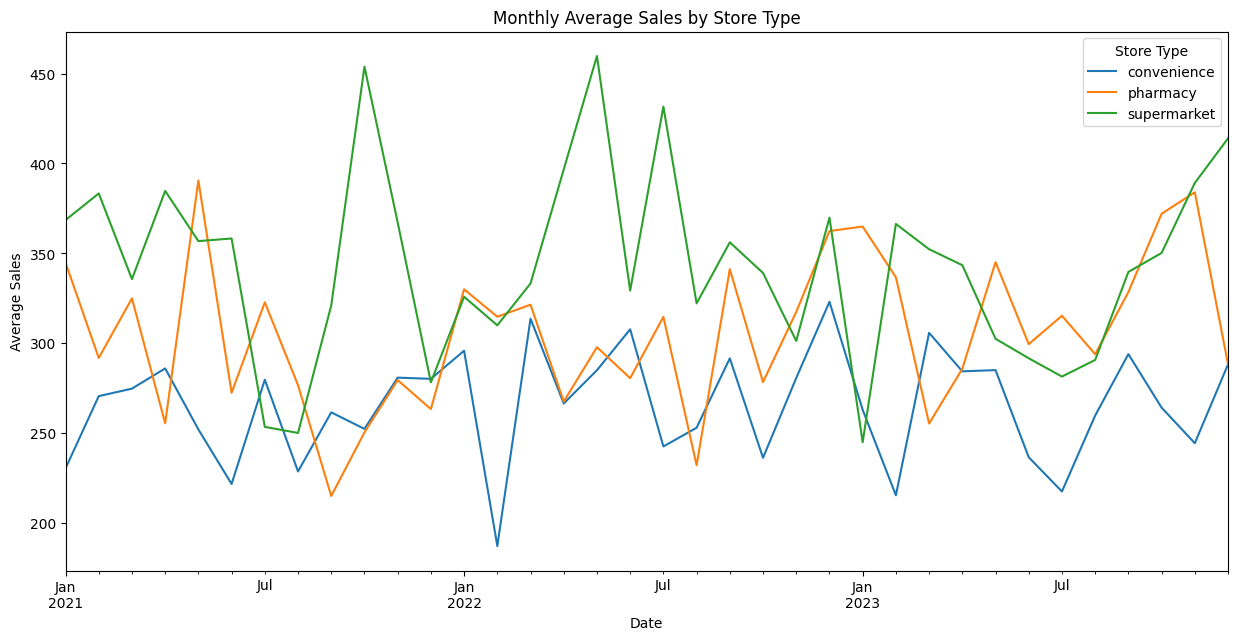

In [39]:
# 10. Store type performance over time
store_type_sales = df.groupby([df.index.to_period('M'), 'Store_Type'])['Sales'].mean().unstack()
store_type_sales.plot(figsize=(15, 7))
plt.title('Monthly Average Sales by Store Type')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(title='Store Type')
plt.show()

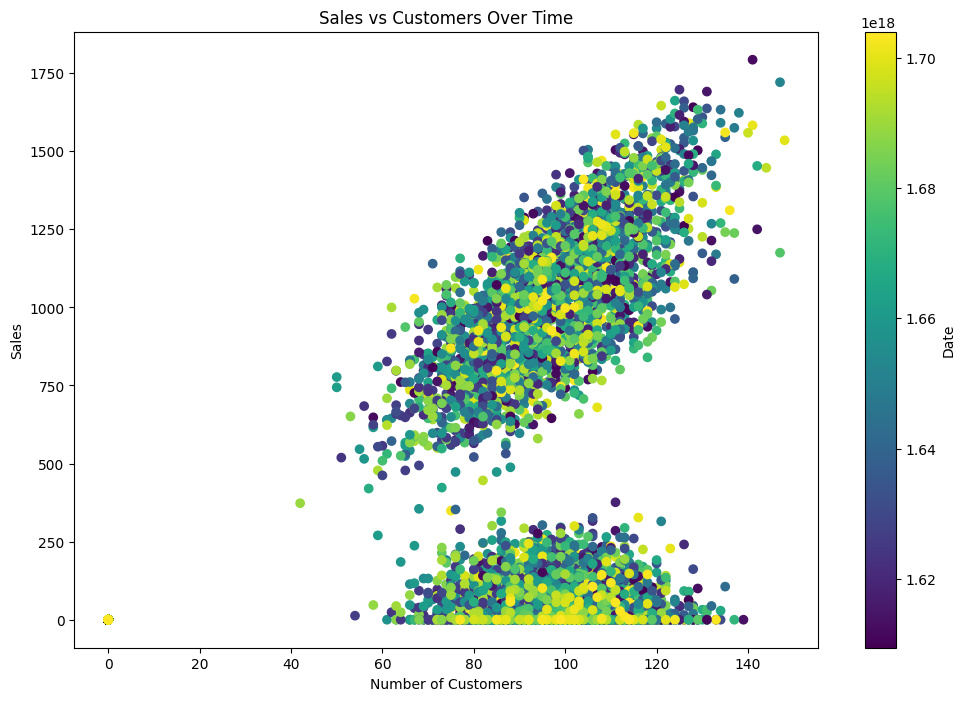

In [41]:
# 12. Sales vs Customers scatter plot with time color gradient
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Customers'], df['Sales'], c=df.index, cmap='viridis')
plt.colorbar(scatter, label='Date')
plt.title('Sales vs Customers Over Time')
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.show()

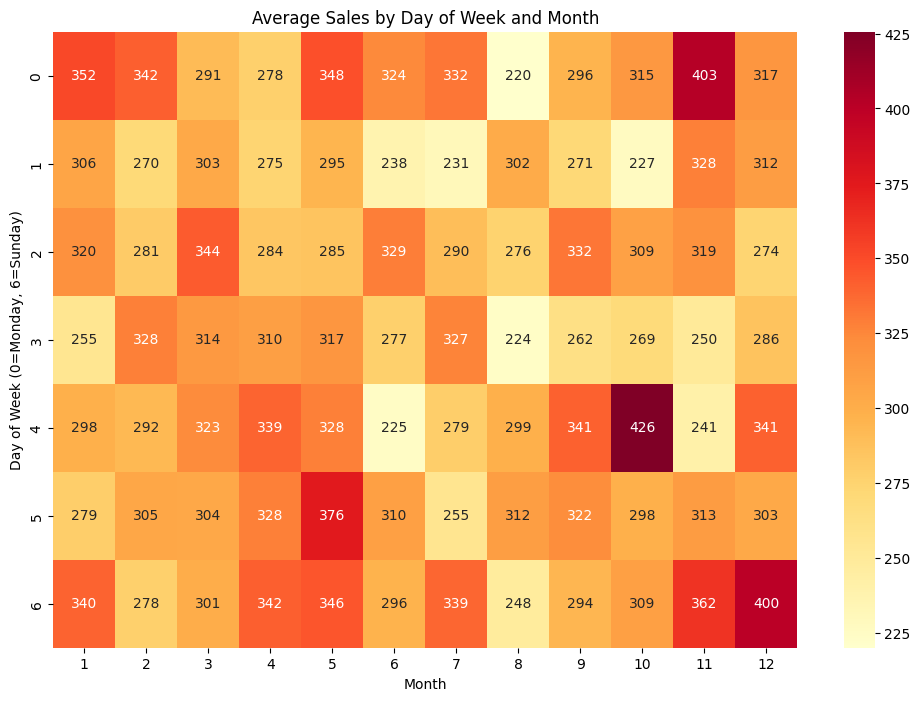

In [42]:
# 13. Heatmap of sales by day of week and month
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
sales_heatmap = df.pivot_table(values='Sales', index='DayOfWeek', columns='Month', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(sales_heatmap, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Sales by Day of Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.show()

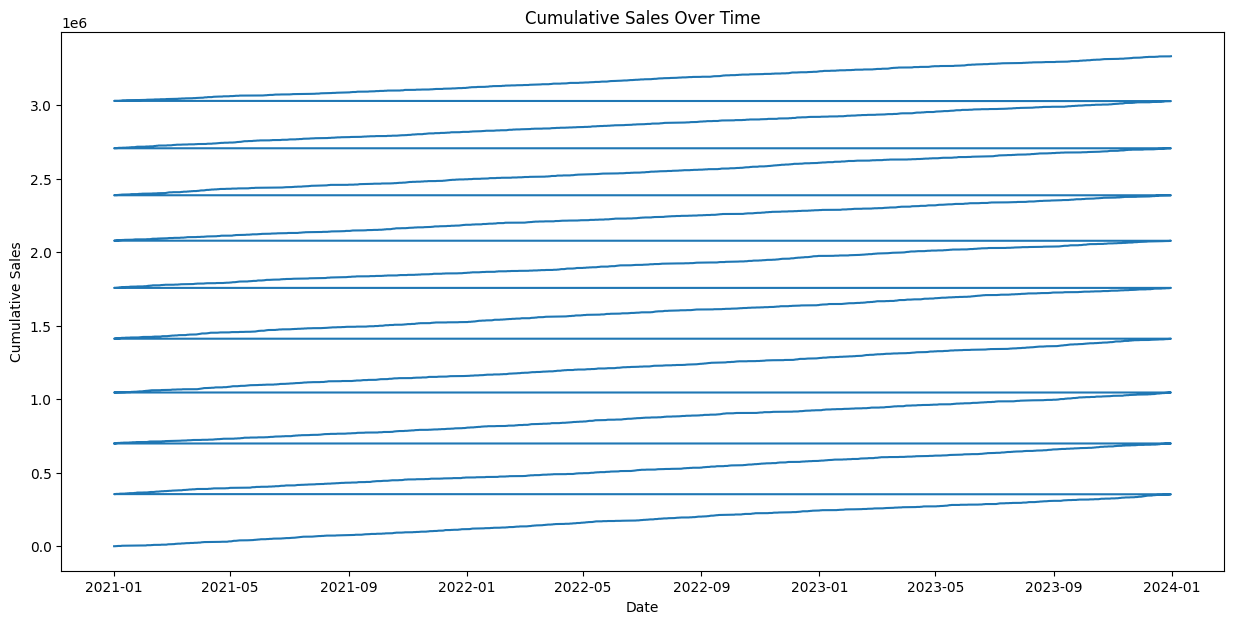

In [43]:
# 14. Cumulative sales
df['CumulativeSales'] = df['Sales'].cumsum()
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['CumulativeSales'])
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.show()

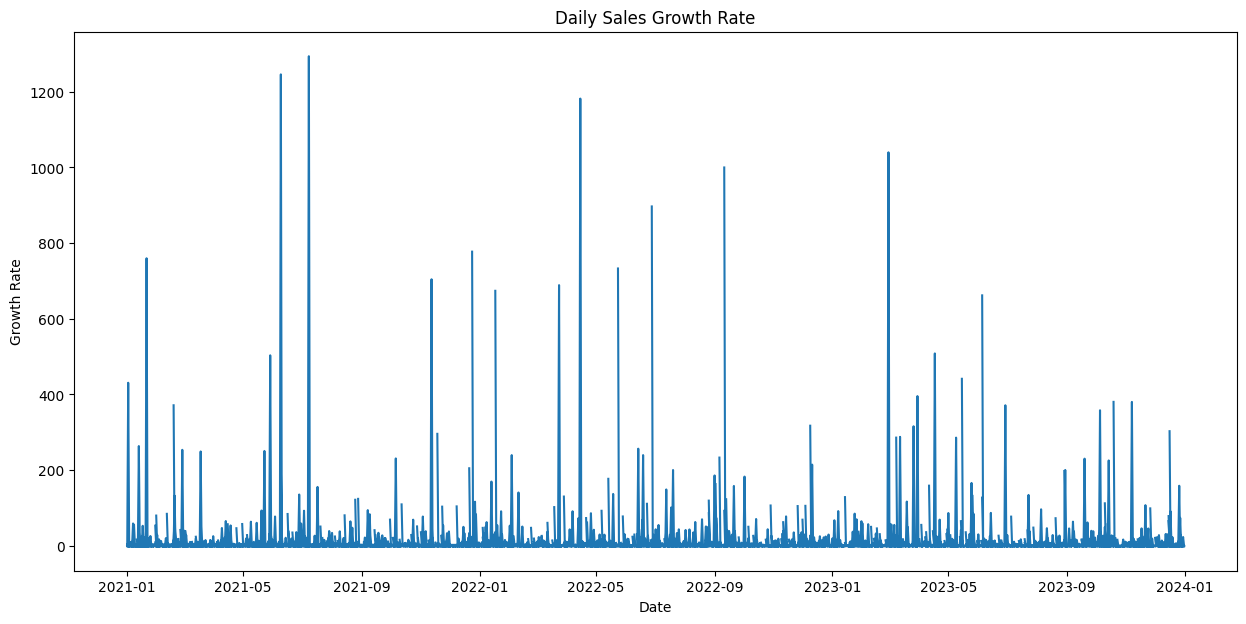

In [44]:
# 15. Sales growth rate
df['SalesGrowthRate'] = df['Sales'].pct_change()
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['SalesGrowthRate'])
plt.title('Daily Sales Growth Rate')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.show()

In [52]:
# # 16. Moving average and standard deviation
# window = 30  # 30-day window
# df['MA30'] = df['Sales'].rolling(window=window).mean()
# df['SD30'] = df['Sales'].rolling(window=window).std()

# plt.figure(figsize=(15, 7))
# plt.plot(df.index, df['Sales'], label='Daily Sales')
# plt.plot(df.index, df['MA30'], label=f'{window}-day Moving Average')
# plt.fill_between(df.index, df['MA30'] - df['SD30'], df['MA30'] + df['SD30'], alpha=0.2)
# plt.title(f'Daily Sales with {window}-day Moving Average and Standard Deviation')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.legend()
# plt.show()

In [55]:
features_to_remove = ['MA30', 'SD30', 'SalesGrowthRate','IsHoliday','CumulativeSales']
df_cleaned = df.drop(columns=features_to_remove, errors='ignore')

In [56]:
df_cleaned

,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales,Year,Month,DayOfWeek,is_holiday
Date,,,,,,,,,,,,
2021-01-01,1,supermarket,1,0,0,0,124,0,2021,1,4,1
2021-01-02,1,pharmacy,1,0,0,0,87,0,2021,1,5,0
2021-01-03,1,supermarket,1,1,0,0,74,778,2021,1,6,0
2021-01-04,1,supermarket,0,1,0,0,0,0,2021,1,0,0
2021-01-05,1,pharmacy,1,1,0,0,76,1002,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,10,pharmacy,1,0,1,0,112,28,2023,12,2,0
2023-12-28,10,convenience,1,0,0,0,111,55,2023,12,3,0
2023-12-29,10,convenience,1,0,0,0,99,0,2023,12,4,0


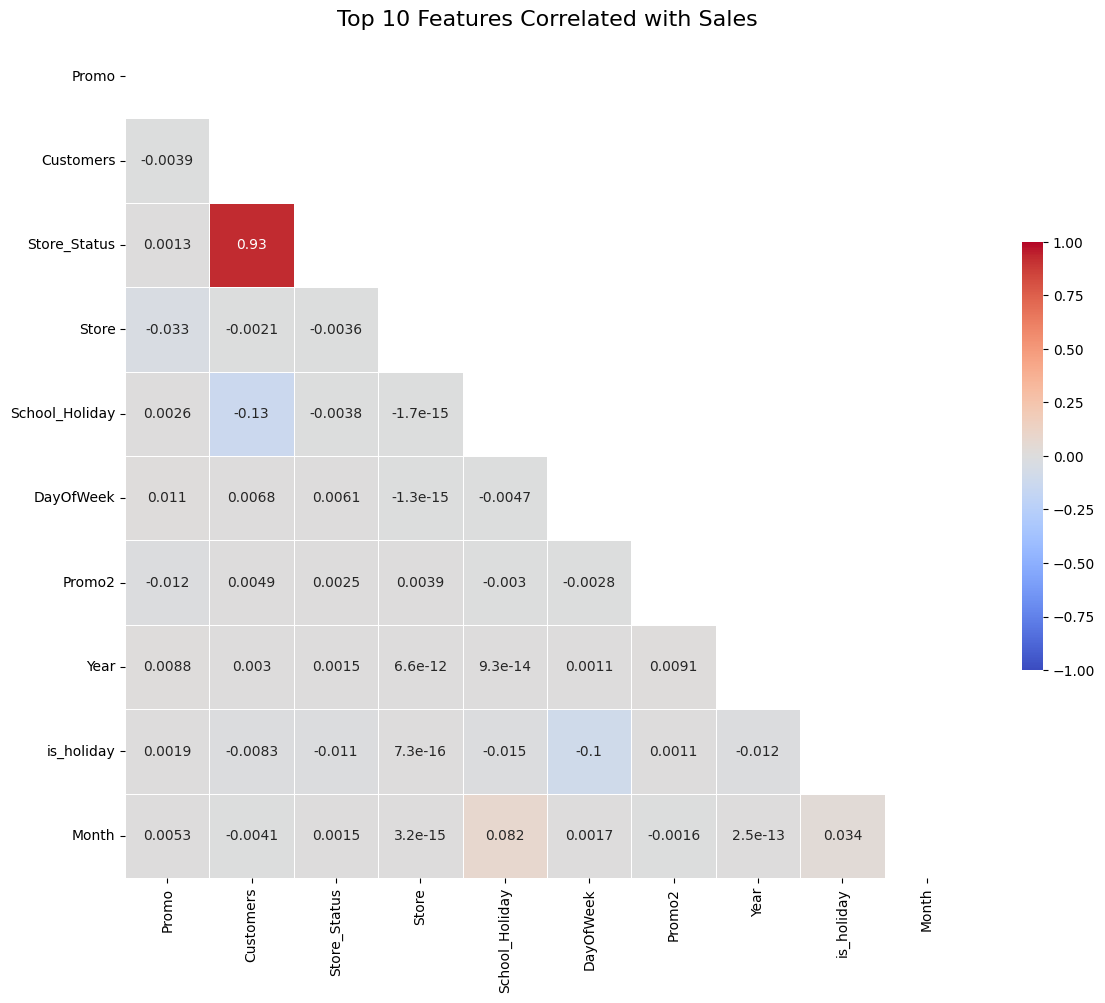

Correlations with Sales:
Promo             0.888812
Customers         0.243039
Store_Status      0.220830
Store             0.032167
School_Holiday    0.027882
DayOfWeek         0.011325
Promo2            0.008017
Year              0.007275
is_holiday        0.002346
Month             0.000853
Name: Sales, dtype: float64


In [57]:
# Assuming df is your DataFrame
# Select numeric columns for correlation analysis
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlations
correlations = df_cleaned[numeric_columns].corr()['Sales'].abs().sort_values(ascending=False)

# Select top 10 correlated features (excluding 'Sales' itself)
top_features = correlations[1:11].index.tolist()

# Create correlation matrix for these features
f_correlation = df[top_features].corr()

# Generate a mask for the upper triangle
f_mask = np.triu(np.ones_like(f_correlation, dtype=bool))

# Set up the matplotlib figure
f_fig, f_ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(f_correlation, mask=f_mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Top 10 Features Correlated with Sales', fontsize=16)
plt.tight_layout()
plt.show()

# Print the correlation values
print("Correlations with Sales:")
print(correlations[top_features])
